In [3]:
# Force garbage collection
import gc
gc.collect()

476

In [4]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve

In [5]:
from sklearn.metrics import average_precision_score
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

In [6]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2


In [7]:
year_to_evaluate = 2007

In [8]:
# read the merged data
# mod_data = pd.read_parquet('../Clean_Data/Model_Data/2001_2020_Downsample/Features_w_Label_Downsampled.parquet')
#Eval_data = pd.read_parquet('../Clean_Data/Model_Data/2020/Features_w_Label_2020_OOT.parquet')
Eval_data = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{year_to_evaluate}_predictions.csv')

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_35776\2198558942.py:4: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  Eval_data = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/{year_to_evaluate}_predictions.csv')


In [ ]:
# mod_data = pd.read_parquet('../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_2001_2020.parquet')

In [8]:
feature_list = [#'day',
                    'dead_fuel_moisture_1000hr',
                    'dead_fuel_moisture_100hr', 
                    #'pdsi_pre_interpolated',
                    'pdsi', 
                    #'pdsi_class', 
                    'max_air_temperature',
                    'max_relative_humidity', 
                    #'max_wind_speed', 
                    'min_air_temperature',
                    'min_relative_humidity', 
                    'precipitation_amount', 
                    'specific_humidity',
                    'surface_downwelling_shortwave_flux_in_air',
                    #'wind_from_direction',
                    'wind_speed', 
                    'wind_direction_category', 
                    'SWE', 
                    'Band1',
                    'LAI',
                    'IS_FIRE',
                    #'NWCG_CAUSE_CLASSIFICATION', 
                    #'min_FIRE_SIZE', 
                    #'max_FIRE_SIZE',
                    #'veg_type_details', 
                    #'fire_attribute', 
                    'veg', 
                    'slope_avg', 
                    'slope_max',
                    'road_density_km_km2']

In [25]:
Eval_data.dtypes

lon                                          float64
lat                                          float64
day                                           object
dead_fuel_moisture_1000hr                    float64
dead_fuel_moisture_100hr                     float64
pdsi_pre_interpolated                        float64
pdsi_class                                   float64
max_air_temperature                          float64
max_relative_humidity                        float64
max_wind_speed                               float64
min_air_temperature                          float64
min_relative_humidity                        float64
precipitation_amount                         float64
specific_humidity                            float64
surface_downwelling_shortwave_flux_in_air    float64
wind_from_direction                          float64
wind_speed                                   float64
SWE                                          float64
Band1                                        f

In [10]:
# covet day to datetime
Eval_data['day'] = pd.to_datetime(Eval_data['day'], format='%Y-%m-%d', errors='coerce')

In [10]:
# define a function to plot the wind direction
def plot_wind_direction(data):
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    directions = np.deg2rad(data['wind_from_direction'])
    ax.scatter(directions, np.ones_like(directions), c='r', label='Present Directions')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks(np.deg2rad(np.arange(0, 360, 45)))
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    plt.title("Wind Directions")
    plt.legend()
    plt.show()

In [12]:
month_list_map = {'north': [1,10,11,12], 
                  'south': [10,11,12,1,2,3]}
# wind_direction_range_map = {'north': [315, 90],
#                             'south': [360, 100]}

In [13]:
def data_prep(data, eval_dat=False, eval_year = 2020, area = 'all', 
              wind_speed_threshold = 0, 
              wind_speed_region = ">=",
              fire_size_threshold = 0,
              wind_direction_range = [0, 360],
              month_list = [1,2,3,4,5,6,7,8,9,10,11,12]):
    # keep human fire
    # data['NWCG_CAUSE_CLASSIFICATION'] = data['NWCG_CAUSE_CLASSIFICATION'].astype(str)
    # data = data[(data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (data['IS_FIRE'] == 0)]
    # print after filtering the value count of NWCG_CAUSE_CLASSIFICATION in a sentence
    # print('After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:')
    # print(data['NWCG_CAUSE_CLASSIFICATION'].value_counts())

    # check if Year column exists, if not, add it
    if 'Year' not in data.columns:
        data['Year'] = data['day'].dt.year
        # print year column is added in a sentence
        print('Year column is added')

    # ceck if Month column exists, if not, add it
    if 'Month' not in data.columns:
        data['Month'] = data['day'].dt.month
        # print month column is added in a sentence
        print('Month column is added')
    
    month_list = month_list_map[area] if area in month_list_map else month_list

    # print sentence like Step1 filtered Month
    print(f'Step1 filtered Month')
    # filter data to be in month_list
    data = data[data['Month'].isin(month_list)]
    # print the nunique values of month in a sentence
    print('The unique values of month is:')
    print(data['Month'].unique())

    # if it is not evaluation data, then filter the year to be between year-6 and year-1
    if not eval_dat:
        data = data[(data['Year'] >= (eval_year - 6)) & (data['Year'] <= (eval_year - 1))]
        # print after filtering, the min and max year is
        print('After filtering, the min and max year is:')
        print(data['Year'].min(), data['Year'].max())
    # if it is evaluation data, ensure the year is eval_year
    else:
        # check the unique values of year
        print('The unique values of year is:')
        print(data['Year'].unique())
        # confirm the year is eval_year
        assert data['Year'].unique()[0] == eval_year, 'The year is not equal to eval_year'

    if area == "south":
        data = data[data['lat'] < 35.75]
        # print the min and max lat in a sentence
        print('The min and max lat is:')
        print(data['lat'].min(), data['lat'].max())
    elif area == "north":
        data = data[data['lat'] >= 35.75]
        # print the min and max lat in a sentence
        print('The min and max lat is:')
        print(data['lat'].min(), data['lat'].max())

    # filter the data using wind_speed_threshold and wind_speed_region (>= or <)
    if wind_speed_region == ">=":
        data = data[data['wind_speed'] >= wind_speed_threshold]
    elif wind_speed_region == "<":
        data = data[data['wind_speed'] < wind_speed_threshold]
    else:
        print('The wind_speed_region is not valid')
    
    print('The min and max wind speed is:')
    print(data['wind_speed'].min(), data['wind_speed'].max())

    wind_direction_min, wind_direction_max = wind_direction_range
    if wind_direction_min < wind_direction_max:
        # filter the data to be between wind_direction_min and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= wind_direction_max)]
    else: 
        # filter the data to be between wind_direction_min and 360 or between 0 and wind_direction_max
        data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= 360) | (data['wind_from_direction'] >= 0) & (data['wind_from_direction'] <= wind_direction_max)]

    
    data = data[data['min_FIRE_SIZE'] >= fire_size_threshold]
    # print the min and max fire size in a sentence
    print('The min and max fire size is:')
    print(data['min_FIRE_SIZE'].min(), data['min_FIRE_SIZE'].max())

    #plot_wind_direction(data)

    #data['wind_direction_category'] = data['wind_direction_category'].cat.remove_unused_categories()

    #data['veg'] = data['veg'].astype('category')
    #data['veg'] = data['veg'].cat.remove_unused_categories()

    # data = data[feature_list]
    # cat_columns = ['wind_direction_category','veg']
    # # check if both cat_columns are in data
    # if all(col in data.columns for col in cat_columns):
    #     data = pd.get_dummies(data, columns=cat_columns)
    # else:
    #     print('One of the columns is not in data')

    # PRINT shape of data, and the mean and sum of IS_FIRE
    print('The shape of data is:')
    print(data.shape)
    print('The mean of IS_FIRE is:')
    print(data['IS_FIRE'].mean())
    print('The count of IS_FIRE is:')
    print(data['IS_FIRE'].sum())

    return data

In [12]:
def calculate_precision_recall(y_true, y_pred_proba, threshold, print_output=False):
    y_pred = (y_pred_proba > threshold).astype(int)
    confusion = confusion_matrix(y_true, y_pred)
    precision = confusion[1, 1] / (confusion[1, 1] + confusion[0, 1])
    recall = confusion[1, 1] / (confusion[1, 1] + confusion[1, 0])
    # F1 score
    f1 = 2 * (precision * recall) / (precision + recall)
    if print_output:
        print(f'Threshold: {threshold:.2f}')
        print(f'Precision: {precision * 100:.2f}%')
        print(f'Recall: {recall * 100:.2f}%')
        print("Confusion Matrix")
        print(pd.DataFrame(confusion, index=['True Neg', 'True Pos'], columns=['Pred Neg', 'Pred Pos']))
    # get TP, TN, FP, FN
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    return TP, TN, FP, FN, precision, recall, f1

def evaluate_model(model, test_data, features, label_col, threshold = 0.5, print_output=False, plot_ROC=False):
    X_test = test_data[features]
    y_test = test_data[label_col]
    # predict the probability of fire
    y_pred = model.predict_proba(X_test)[:, 1]
    # calculate the roc_auc_score
    roc_auc = roc_auc_score(y_test, y_pred)
    # print roc_auc in a sentence
    # print(f"ROC AUC: {roc_auc:.2f}")
    # Calculate precision and recall values
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Calculate the area under the precision-recall curve
    auc_pr = auc(recall, precision)
    # print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    if print_output:
        print(f"ROC AUC: {roc_auc:.2f}")
        print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    if plot_ROC:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    # calculate precision and recall at thresholds 0.5
    TP, TN, FP, FN, precision5, recall5, f15 = calculate_precision_recall(y_test, y_pred, threshold, print_output)
    return roc_auc, auc_pr, TP, TN, FP, FN, precision5, recall5, f15

## North

After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:
NWCG_CAUSE_CLASSIFICATION
None                                                  6251003
'Human'                                                  8848
'Human', 'Missing data/not specified/undetermined'         54
'Human', 'Natural'                                         13
Name: count, dtype: int64
Month column is added
The unique values of month is:
[ 1 10 11 12]
The unique values of year is:
[2007]
The min and max lat is:
35.775000000000006 41.983333333333334
The min and max wind speed is:
6.0 23.399999618530273


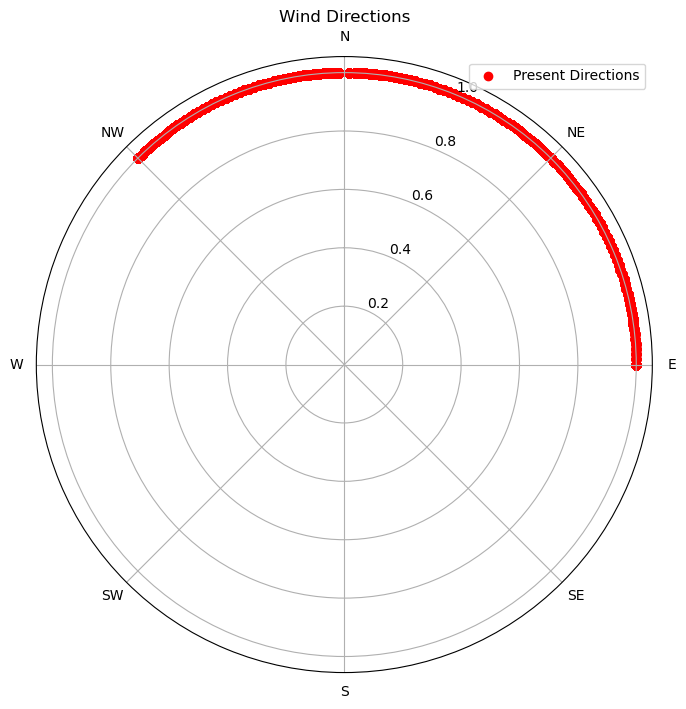

The shape of data is:
(79378, 39)
The mean of IS_FIRE is:
0.0008440625866108997
The count of IS_FIRE is:
67


In [ ]:
# supress warnings
warnings.filterwarnings("ignore")
Eval_north = data_prep(Eval_data, eval_dat=True, 
                       eval_year=year_to_evaluate, 
                       area='north', 
                       wind_speed_threshold=6, 
                       wind_direction_range=[315, 90], month_list=[1,10,11,12])

After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:
NWCG_CAUSE_CLASSIFICATION
None                                                  15183400
'Human'                                                 102582
'Human', 'Missing data/not specified/undetermined'         740
'Human', 'Natural'                                         104
Name: count, dtype: int64
Year column is added
Month column is added
The unique values of month is:
[ 1 10 11 12]
After filtering, the min and max year is:
2001 2006
The min and max lat is:
35.775000000000006 41.983333333333334
The min and max wind speed is:
6.0 21.80000114440918


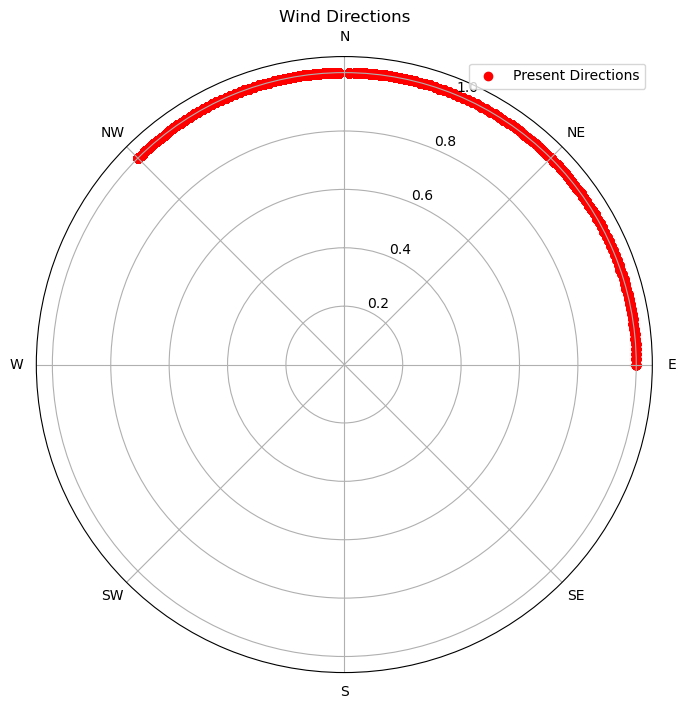

The shape of data is:
(36495, 39)
The mean of IS_FIRE is:
0.007151664611590629
The count of IS_FIRE is:
261


In [15]:
Train_north = data_prep(mod_data, eval_dat=False,
                        eval_year=year_to_evaluate, 
                        feature_list=feature_list, 
                        area='north', 
                        wind_speed_threshold=6, 
                        wind_direction_range=[315, 90], month_list=[1,10,11,12])

In [ ]:
# Train XGBoost model
X_train = Train_north.drop(columns=['IS_FIRE'])
y_train = Train_north['IS_FIRE']

# Define the parameters for a simpler model
params = {
    #'max_depth': 3,  # Reduce the maximum depth of the trees
    #'min_child_weight': 5,  # Increase the minimum sum of instance weight needed in a child
    #'gamma': 0.1,  # Increase the minimum loss reduction required to make a further partition
    #'subsample': 0.8,  # Reduce the subsample ratio of the training instances
    #'colsample_bytree': 0.8,  # Reduce the subsample ratio of columns when constructing each tree
    #'learning_rate': 0.1,  # Increase the learning rate
    #'n_estimators': 10,  # Reduce the number of boosting rounds
    'eval_metric':'logloss'
}

# Create the XGBoost model with the simpler parameters
mod_1 = xgb.XGBClassifier(**params)
mod_1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [18]:
X_train.columns

Index(['dead_fuel_moisture_1000hr', 'dead_fuel_moisture_100hr', 'pdsi',
       'max_air_temperature', 'max_relative_humidity', 'min_air_temperature',
       'min_relative_humidity', 'precipitation_amount', 'specific_humidity',
       'surface_downwelling_shortwave_flux_in_air', 'wind_speed', 'SWE',
       'Band1', 'LAI', 'slope_avg', 'slope_max', 'road_density_km_km2',
       'wind_direction_category_N', 'wind_direction_category_NE',
       'wind_direction_category_W', 'wind_direction_category_NW',
       'veg_Agriculture ', 'veg_Barren ', 'veg_Native Chapparal ',
       'veg_Native Coastal Sage Scrub ', 'veg_Native Conifer Alpine ',
       'veg_Native Conifer Forest ', 'veg_Native Desert ',
       'veg_Native Grassland ', 'veg_Native Inland Scrub ',
       'veg_Native Oak Woodland ', 'veg_Native Wetland ',
       'veg_Non-native forest ', 'veg_Non-native grassland ',
       'veg_Non-native shrub ', 'veg_Riparian ', 'veg_Urban ', 'veg_Water '],
      dtype='object')

In [ ]:
features = X_train.columns
evaluate_model(mod_1, Eval_north, features, "IS_FIRE",threshold=0.1 ,print_output=True, plot_ROC=False)

ROC AUC: 0.78
Area Under Precision-Recall Curve (AUC-PR): 0.01
Threshold: 0.10
Precision: 3.01%
Recall: 7.46%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg     79150       161
True Pos        62         5


(0.777002851235369,
 0.006277494747682666,
 5,
 79150,
 161,
 62,
 0.030120481927710843,
 0.07462686567164178,
 0.04291845493562232)

In [70]:
# print feature importance
feature_importances = pd.Series(mod_1.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

wind_direction_category_NE                   0.095890
Band1                                        0.073231
veg_Native Inland Scrub                      0.059227
veg_Native Coastal Sage Scrub                0.054956
dead_fuel_moisture_1000hr                    0.045810
min_relative_humidity                        0.045042
road_density_km_km2                          0.042875
dead_fuel_moisture_100hr                     0.038865
precipitation_amount                         0.038780
slope_max                                    0.036230
veg_Riparian                                 0.036140
veg_Native Conifer Forest                    0.035801
veg_Agriculture                              0.035764
max_relative_humidity                        0.035537
min_air_temperature                          0.035529
LAI                                          0.035438
surface_downwelling_shortwave_flux_in_air    0.033198
slope_avg                                    0.033140
wind_speed                  

## Shap Value

In [71]:
import shap

In [73]:
explainer = shap.Explainer(mod_1)
shap_values = explainer(X_train)

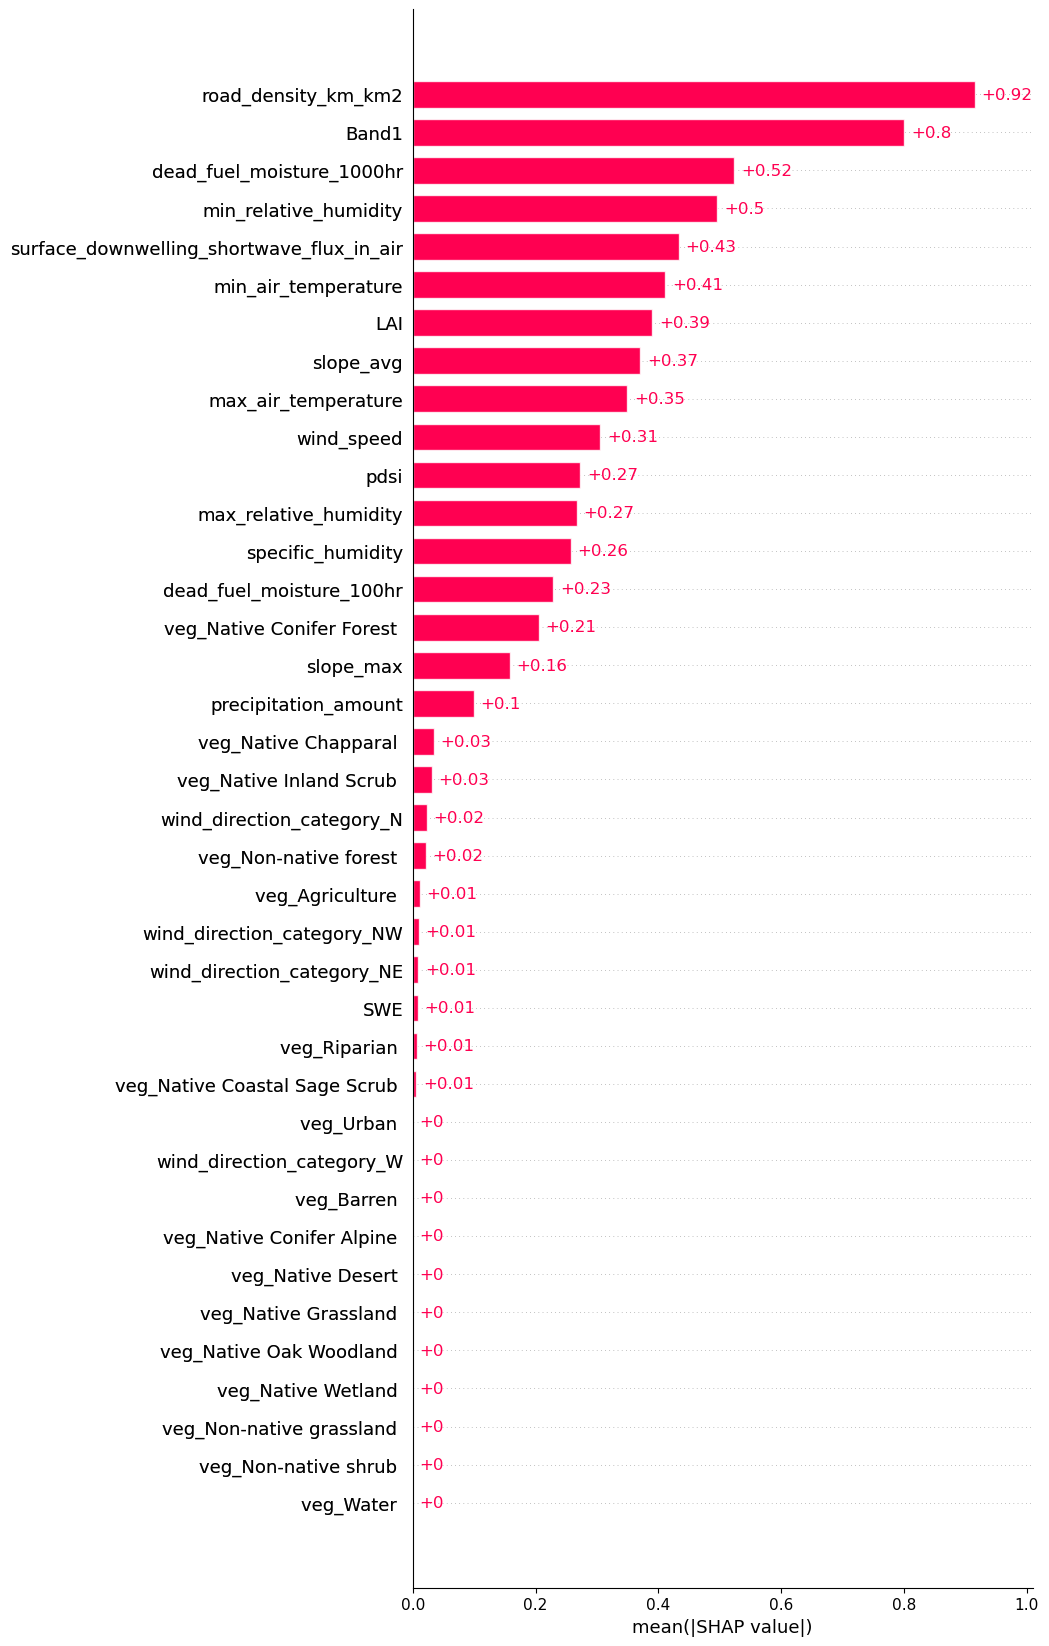

In [74]:
# By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.
shap.plots.bar(shap_values, max_display = 50)

## South

After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:
NWCG_CAUSE_CLASSIFICATION
None                                                  15183400
'Human'                                                 102582
'Human', 'Missing data/not specified/undetermined'         740
'Human', 'Natural'                                         104
Name: count, dtype: int64
Year column is added
Month column is added
The unique values of month is:
[ 1  2  3  4  9 10 11 12]
After filtering, the min and max year is:
2001 2006
The min and max lat is:
32.525000000000006 35.733333333333334
The min and max wind speed is:
6.0 17.100000381469727


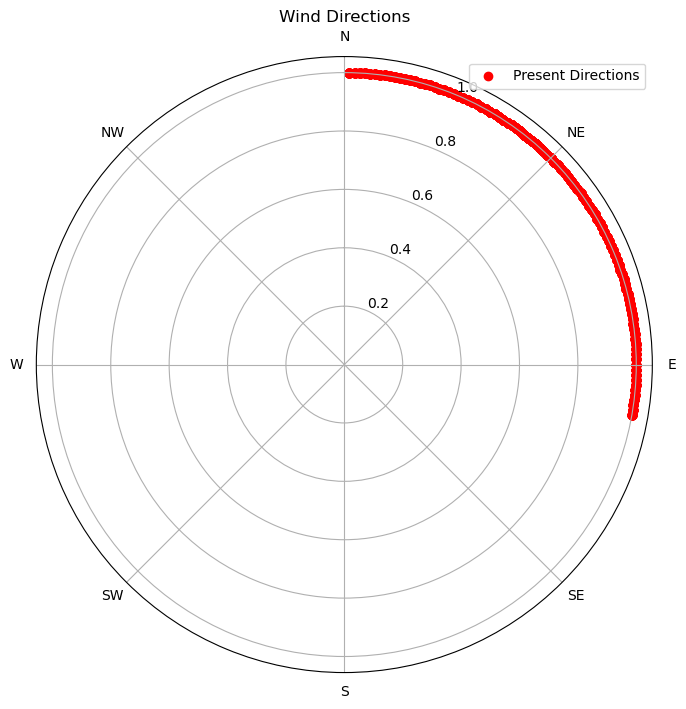

The shape of data is:
(7046, 37)
The mean of IS_FIRE is:
0.01319897814362759
The count of IS_FIRE is:
93


In [ ]:
# Train_south = data_prep(mod_data, eval_dat=False,
#                         eval_year=year_to_evaluate, 
#                         feature_list=feature_list, 
#                         area='south', 
#                         wind_speed_threshold=6, 
#                         wind_direction_range=[360, 100], 
#                         month_list=[9,10,11,12,1,2,3,4])

Step1 filtered Month
The unique values of month is:
[ 1  2  3 10 11 12]
The unique values of year is:
[2007]
The min and max lat is:
32.525000000000006 35.733333333333334
The min and max wind speed is:
0.4 16.1
The min and max fire size is:
10.0 197990.0
The shape of data is:
(46, 58)
The mean of IS_FIRE is:
1.0
The count of IS_FIRE is:
46


In [15]:
import pickle

# Load the model
with open(f'../Model/6_year_completed/predict_{year_to_evaluate}_6yr_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Now you can use the loaded_model to make predictions or inspect it
print(loaded_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)


In [16]:
# get features from loaded_model
features = loaded_model.get_booster().feature_names
print(features)

['dead_fuel_moisture_1000hr', 'dead_fuel_moisture_100hr', 'max_air_temperature', 'max_relative_humidity', 'min_air_temperature', 'min_relative_humidity', 'precipitation_amount', 'specific_humidity', 'surface_downwelling_shortwave_flux_in_air', 'wind_speed', 'SWE', 'Band1', 'LAI', 'pdsi', 'slope_avg', 'slope_max', 'road_density_km_km2', 'wind_direction_category_N', 'wind_direction_category_NE', 'wind_direction_category_E', 'wind_direction_category_SE', 'wind_direction_category_S', 'wind_direction_category_SW', 'wind_direction_category_W', 'wind_direction_category_NW', 'veg_Agriculture ', 'veg_Barren ', 'veg_Native Chapparal ', 'veg_Native Coastal Sage Scrub ', 'veg_Native Conifer Alpine ', 'veg_Native Conifer Forest ', 'veg_Native Desert ', 'veg_Native Grassland ', 'veg_Native Inland Scrub ', 'veg_Native Oak Woodland ', 'veg_Native Wetland ', 'veg_Non-native forest ', 'veg_Non-native grassland ', 'veg_Non-native shrub ', 'veg_Riparian ', 'veg_Urban ', 'veg_Water ']


Text(0.5, 1.0, 'Feature Importance from XGBoost Model')

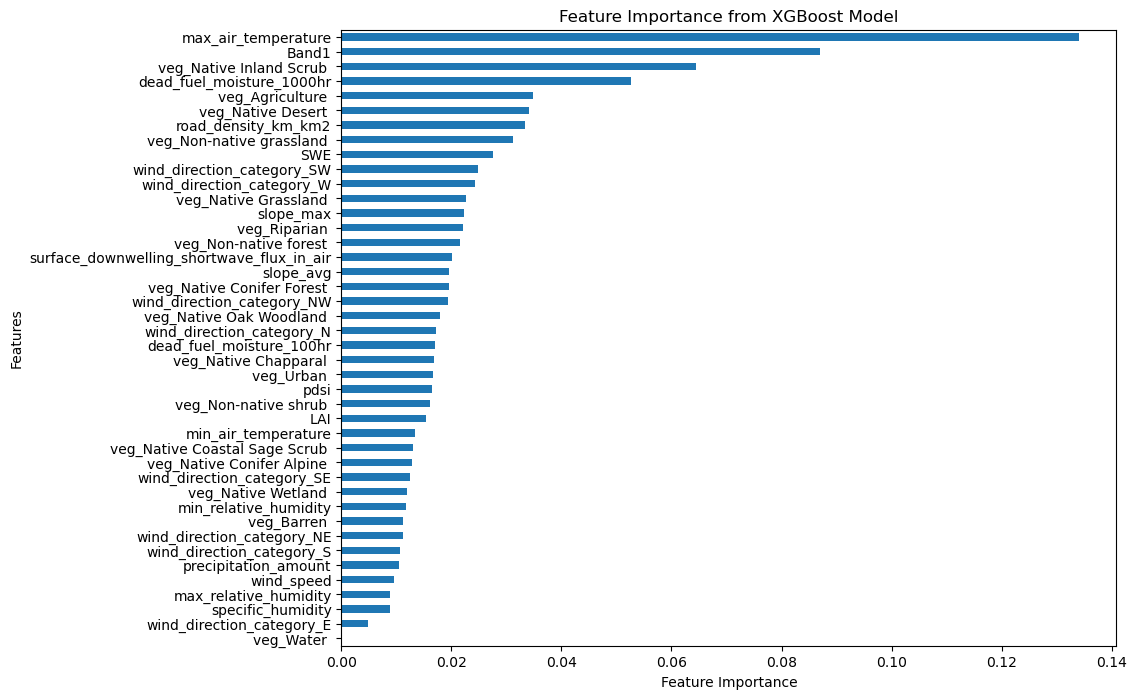

In [17]:
# print importance
feature_importances = pd.Series(loaded_model.feature_importances_, index=features)
feature_importances = feature_importances.sort_values(ascending=True)
# plot feature importance
plt.figure(figsize=(10, 8))
feature_importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from XGBoost Model')

In [22]:
import shap
explainer = shap.Explainer(loaded_model)
# explain the model's predictions using SHAP in the evaluation data
# shap_values = explainer(Eval_south[features])
#shap.summary_plot(shap_values, Eval_south[features], max_display=20)

In [42]:
Eval_south = data_prep(Eval_data, eval_dat=True,
                          eval_year=year_to_evaluate, 
                          fire_size_threshold=10,
                          #wind_speed_threshold=6,
                          area='south')

Step1 filtered Month
The unique values of month is:
[ 1  2  3 10 11 12]
The unique values of year is:
[2007]
The min and max lat is:
32.525000000000006 35.733333333333334
The min and max wind speed is:
0.4 16.1
The min and max fire size is:
10.0 197990.0
The shape of data is:
(46, 58)
The mean of IS_FIRE is:
1.0
The count of IS_FIRE is:
46


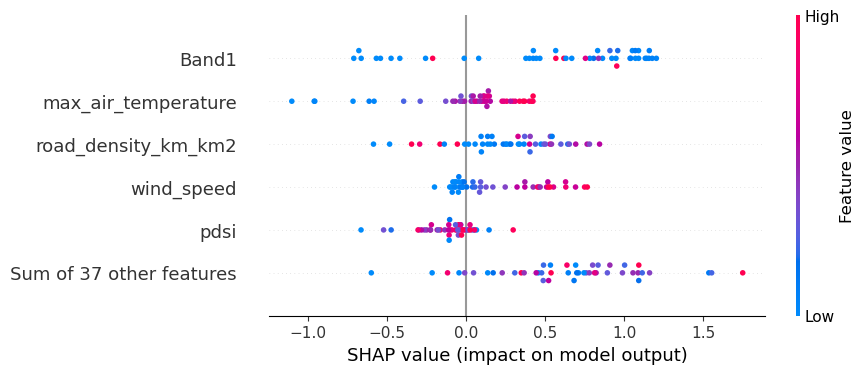

In [47]:
positive_samples = Eval_south[Eval_south['IS_FIRE'] == 1]
shap_values = explainer(positive_samples[features])
shap.plots.beeswarm(shap_values, max_display=6, order=shap_values.abs.max(0)) # mean absolute value of SHAP values

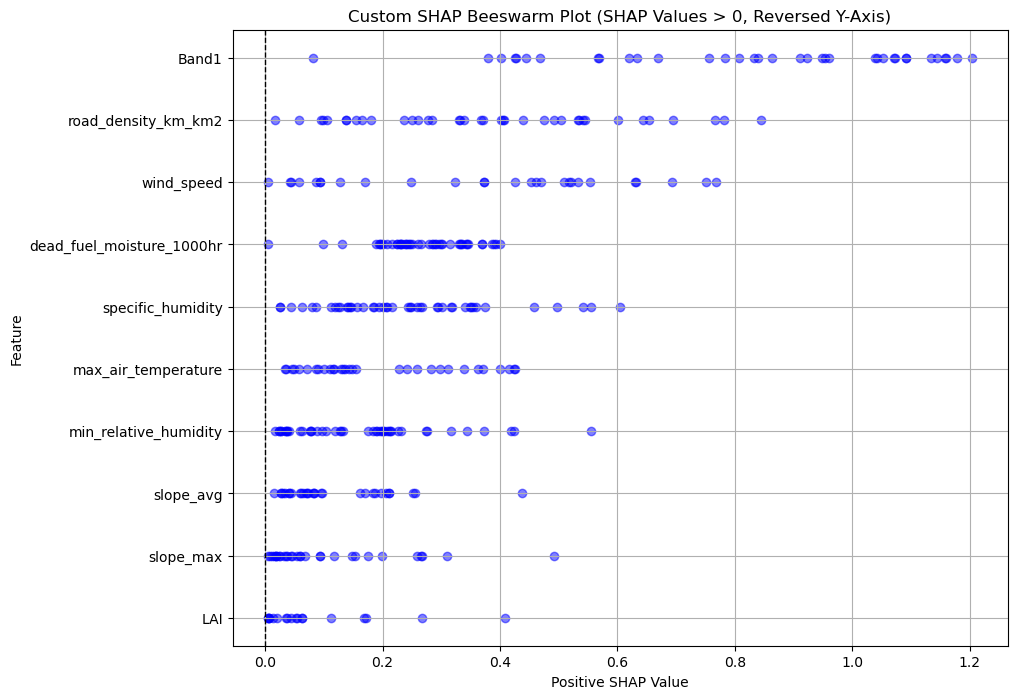

In [50]:
shap_df = pd.DataFrame(shap_values.values, columns=Eval_south[features].columns)

# Filter only positive SHAP values
positive_shap_df = shap_df[shap_df > 0]

# Compute the mean of positive SHAP values for ranking
positive_mean_shap = positive_shap_df.mean().sort_values(ascending=False)

# Sort features based on their positive contributions
sorted_features = positive_mean_shap.index[:10]  # Top 20 features
sorted_positive_shap_values = positive_shap_df[sorted_features]

# Reverse the order of the y-axis
reversed_features = sorted_features[::-1]  # Reverse the order of the features

# Create a custom beeswarm plot
plt.figure(figsize=(10, 8))
for i, feature in enumerate(reversed_features):
    plt.scatter(
        sorted_positive_shap_values[feature],  # SHAP values for the feature
        [i] * len(sorted_positive_shap_values),  # Align points for each feature
        alpha=0.5,
        color="blue",  # Use a single color for simplicity
    )

plt.yticks(range(len(reversed_features)), reversed_features)  # Use reversed order for y-axis labels
plt.axvline(0, color="black", linestyle="--", linewidth=1)  # Add a vertical line at 0
plt.xlabel("Positive SHAP Value")
plt.ylabel("Feature")
plt.title("Custom SHAP Beeswarm Plot (SHAP Values > 0, Reversed Y-Axis)")
plt.grid(True)
plt.show()

Sounth non-wind

After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:
NWCG_CAUSE_CLASSIFICATION
None                                                  15183400
'Human'                                                 102582
'Human', 'Missing data/not specified/undetermined'         740
'Human', 'Natural'                                         104
Name: count, dtype: int64
Year column is added
Month column is added
The unique values of month is:
[ 1  2  3  4  9 10 11 12]
After filtering, the min and max year is:
2001 2006
The min and max lat is:
32.525000000000006 35.733333333333334
The min and max wind speed is:
0.4000000059604645 5.900000095367432


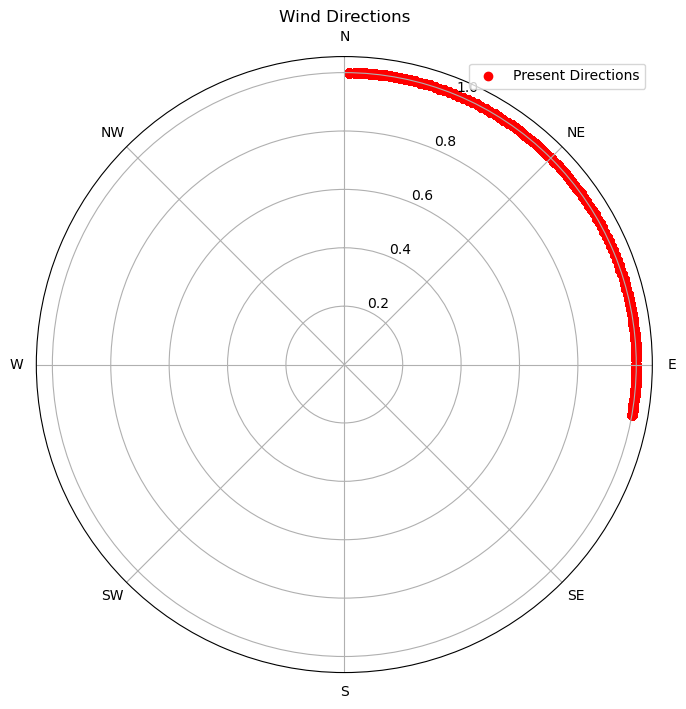

The shape of data is:
(108669, 38)
The mean of IS_FIRE is:
0.00834644654869374
The count of IS_FIRE is:
907


In [41]:
Train_south = data_prep(mod_data, eval_dat=False,
                        eval_year=year_to_evaluate, 
                        feature_list=feature_list, 
                        area='south', 
                        wind_speed_threshold=6, 
                        wind_speed_region="<",
                        wind_direction_range=[360, 100], 
                        month_list=[9,10,11,12,1,2,3,4])

After filtering, the value count of NWCG_CAUSE_CLASSIFICATION is:
NWCG_CAUSE_CLASSIFICATION
None                                                  6251003
'Human'                                                  8848
'Human', 'Missing data/not specified/undetermined'         54
'Human', 'Natural'                                         13
Name: count, dtype: int64
Month column is added
The unique values of month is:
[ 1  2  3  4  9 10 11 12]
The unique values of year is:
[2007]
The min and max lat is:
32.525000000000006 35.733333333333334
The min and max wind speed is:
0.4000000059604645 5.900000095367432


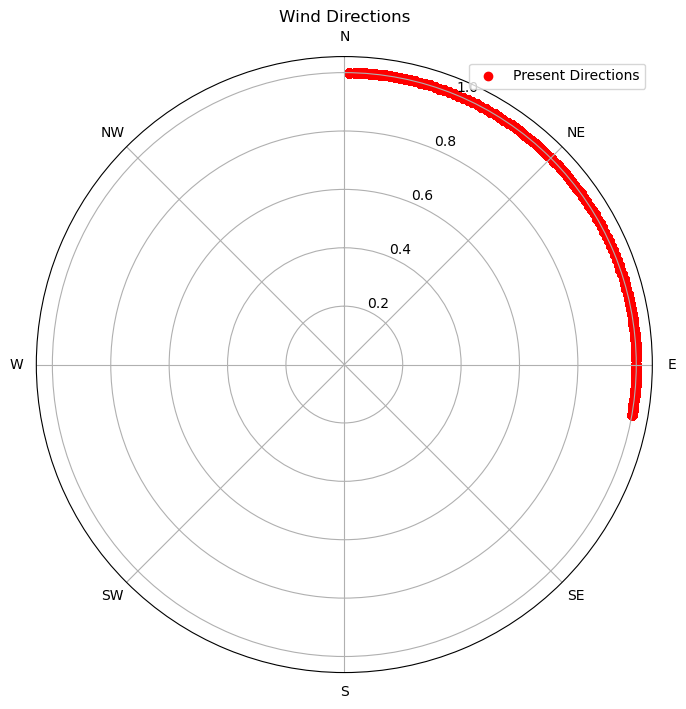

The shape of data is:
(170416, 38)
The mean of IS_FIRE is:
0.002000985822927425
The count of IS_FIRE is:
341


In [42]:
Eval_south = data_prep(Eval_data, eval_dat=True,
                            eval_year=year_to_evaluate, 
                            feature_list=feature_list, 
                            area='south', 
                            wind_speed_threshold=6, 
                            wind_speed_region="<",
                            wind_direction_range=[360, 100], 
                            month_list=[9,10,11,12,1,2,3,4])

In [44]:
# train the model
X_train = Train_south.drop(columns=['IS_FIRE'])
y_train = Train_south['IS_FIRE']

mod_3 = xgb.XGBClassifier(eval_metric='logloss')
mod_3.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [45]:
features = X_train.columns
evaluate_model(mod_3, Eval_south, features, "IS_FIRE", threshold=0.2, print_output=True, plot_ROC=False)

ROC AUC: 0.80
Area Under Precision-Recall Curve (AUC-PR): 0.01
Threshold: 0.20
Precision: 2.84%
Recall: 2.35%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg    169801       274
True Pos       333         8


(0.7969366628402255,
 0.011890562116100036,
 8,
 169801,
 274,
 333,
 0.028368794326241134,
 0.02346041055718475,
 0.025682182985553772)